In [2]:
#r "nuget: TorchSharp-cuda-windows, 0.100.3"
#r "nuget: PureHDF, 1.0.0-alpha.25"

open TorchSharp
open PureHDF

open type TorchSharp.torch
open type TorchSharp.torch.nn
open type TorchSharp.torch.nn.functional
open type TorchSharp.TensorExtensionMethods
open type TorchSharp.torch.utils.data

Installed Packages PureHDF, 1.0.0-alpha.25 TorchSharp-cuda-windows, 0.100.3

In [112]:
#!import "diffusion_utilities.fsx"

torch.cuda.is_available()

Installed Packages PureHDF, 1.0.0-alpha.25 skiasharp, 2.88.3 TorchSharp-cuda-windows, 0.100.3 TorchVision, 0.100.3

True

In [4]:
type ContextUnet (in_channels, n_feat, n_cfeat, h, t_device) as this =
    inherit nn.Module<torch.Tensor * torch.Tensor * Option<torch.Tensor>,Tensor>("ContextUnet")   

    // Initialize the initial convolutional layer
    let init_conv = new ResidualConvBlock(in_channels, n_feat, true, t_device)

    // Initialize the down-sampling path of the U-Net with two levels
    let down1 = new UnetDown(n_feat, n_feat, t_device)        //# down1 #[10, 256, 8, 8]
    let down2 = new UnetDown(n_feat, 2L * n_feat, t_device)    //# down2 #[10, 256, 4,  4]
    
    // original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
    let to_vec = nn.Sequential([| 
        nn.AvgPool2d(4) :> nn.Module<_,_>
        nn.GELU() 
    |])

    // Embed the timestep and context labels with a one-layer fully connected neural network
    let timeembed1 = new EmbedFC(1, 2L*n_feat, t_device)
    let timeembed2 = new EmbedFC(1, 1L*n_feat, t_device)
    let contextembed1 = new EmbedFC(n_cfeat, 2L*n_feat, t_device)
    let contextembed2 = new EmbedFC(n_cfeat, 1L*n_feat, t_device)

    // Initialize the up-sampling path of the U-Net with three levels
    let up0 = nn.Sequential([|
        nn.ConvTranspose2d(2L * n_feat, 2L * n_feat, h/4L, h/4L, device = t_device) :> nn.Module<_,_> // up-sample  
        nn.GroupNorm(8L, 2L * n_feat, device = t_device) // normalize                       
        nn.ReLU()
    |])
    let up1 = new UnetUp(4L * n_feat, n_feat, t_device)
    let up2 = new UnetUp(2L * n_feat, n_feat, t_device)

    // Initialize the final convolutional layers to map to the same number of channels as the input image
    let out = nn.Sequential([|
        nn.Conv2d(2L * n_feat, n_feat, 3, 1, 1, device = t_device) :> nn.Module<_,_> // reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
        nn.GroupNorm(8L, n_feat, device = t_device) // normalize
        nn.ReLU()
        nn.Conv2d(n_feat, in_channels, 3, 1, 1, device = t_device) // map to same number of channels as input
    |])
    do this.RegisterComponents()

    override _.forward((x, t, c)) =
        (*
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        *)
        // x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        // pass the input image through the initial convolutional layer
        let x = init_conv.forward(x)
        // pass the result through the down-sampling path
        let down1 = down1.forward(x)       //[10, 256, 8, 8]
        let down2 = down2.forward(down1)   //[10, 256, 4, 4]
        

        // convert the feature maps to a vector and apply an activation
        let hiddenvec = to_vec.forward(down2)
        
        // mask out context if context_mask == 1
        let c = 
            match c with
            | None -> torch.zeros(x.shape[0], n_cfeat).``to``(x)
            | Some x -> x
        
        // embed context and timestep
        let cemb1 = contextembed1.forward(c).view(-1, n_feat * 2L, 1, 1L)     // (batch, 2*n_feat, 1,1)
        let temb1 = timeembed1.forward(t).view(-1, n_feat * 2L, 1, 1)
        let cemb2 = contextembed2.forward(c).view(-1, n_feat, 1, 1)
        let temb2 = timeembed2.forward(t).view(-1, n_feat, 1, 1)
        // printfn "uunet forward: cemb1 %A. temb1 %A, cemb2 %A temb2 %A hidden %A" cemb1.shape temb1.shape cemb2.shape temb2.shape hiddenvec.shape

        

        
        let _up1 = up0.forward(hiddenvec)
        let _up2 = up1.forward([|cemb1*_up1 + temb1; down2|])  // add and multiply embeddings
        let _up3 = up2.forward([|cemb2*_up2 + temb2; down1|])
        let _out = out.forward(torch.cat([|_up3; x|], 1))
        _out

    

In [108]:
// hyperparameters

// diffusion hyperparameters
let timesteps = 500L
let beta1 = 1e-4
let beta2 = 0.02

// network hyperparameters
let t_device = if torch.cuda.is_available() then torch.device("cuda:0") else torch.device("cpu")
let n_feat = 64 // 64 hidden dimension feature
let n_cfeat = 5 // context vector is of size 5
let height = 16 // 16x16 image
let save_dir = "./weights2/"

// training hyperparameters
let batch_size = 100
let n_epoch = 3
let lrate= 1e-3

In [6]:
// construct DDPM noise schedule
let b_t = (beta2 - beta1).ToTensor(t_device) * torch.linspace(0, 1, timesteps + 1L, device=t_device) + beta1.ToTensor(t_device)
let a_t = 1L.ToTensor(t_device) - b_t
let ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] <- 1L

In [7]:
// construct model
let nn_model = (new ContextUnet(3, n_feat, n_cfeat, height, t_device) :> Module<_,_>).``to``(t_device)

# Training

In [7]:

let dataset = new CustomDataset("sprites.hdf5", "slabels.hdf5", Utilities.transform t_device, false, t_device)

sprite shape: [|89400UL; 16UL; 16UL; 3UL|]
labels shape: [|89400UL; 5UL|]


In [8]:
// construct optimizer
let dataloader = new DataLoader(dataset, batch_size, true, t_device)
let optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [9]:
// helper function: perturbs an image to a specified noise level
let perturb_input(x: Tensor, t: Tensor, noise, t_device) =
    ab_t.sqrt()[TensorIndex.Tensor(t), TensorIndex.None, TensorIndex.None, TensorIndex.None] * x + (1.0.ToTensor(t_device) - ab_t[TensorIndex.Tensor(t), TensorIndex.None, TensorIndex.None, TensorIndex.None]) * noise

In [10]:
// training without context code

// set into train mode
nn_model.train()

for ep in 0..2 do
    Console.WriteLine($"epoch {ep}")
    
    // linearly decay learning rate
    let floatNep = Operators.float n_epoch
    let floatEp = Operators.float ep
    optim.ParamGroups |> Seq.head |> (fun ctrl -> ctrl.LearningRate <- lrate*(1.0-floatEp/floatNep))
    

    // TODO:
    // pbar = tqdm(dataloader, mininterval=2 )

    for batchItem in dataloader do   // x: images

        use d0 = torch.NewDisposeScope()
        optim.zero_grad()
        let x = batchItem["data"].``to``(t_device)
        
        // perturb data
        let noise = torch.randn_like(x, device = t_device)
        let t = torch.randint(1, timesteps + 1L, Size(x.shape[0])).``to``(t_device) 
        let x_pert = perturb_input(x, t, noise, t_device)
        
        // use network to recover noise
        let pred_noise = nn_model.forward((x_pert, t / timesteps.ToTensor(t_device), None))
        
        // # loss is mean squared error between the predicted and true noise
        let loss = mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step() |> ignore

    // save model periodically
    if ep%4=0 || ep = n_epoch-1 then
        if Directory.Exists(save_dir) |> not then
            Directory.CreateDirectory(save_dir) |> ignore
        nn_model.save(save_dir + $"model_{ep}.pth") |> ignore

epoch 0
epoch 1
epoch 2


# Sampling

In [68]:
// helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
let denoise_add_noise(x: Tensor, i: int64, pred_noise: Tensor, z) =
    let z = z |> Option.defaultValue (torch.randn_like(x))
    let noise = b_t.sqrt()[i] * z
    let mean = (x - pred_noise * ((1.0.ToTensor(t_device) - a_t[i]) / (1.0.ToTensor(t_device) - ab_t[i]).sqrt())) / a_t[i].sqrt()
    mean + noise

In [69]:
// sample using standard algorithm
let sample_ddpm(n_sample, save_rate: int64) =
    use _ = torch.no_grad()
    /// x_T ~ N(0, 1), sample initial noise
    let samples = torch.randn([|n_sample; 3L; height; height|], device = t_device)

    // array to keep track of generated steps for plotting
    let intermediate = ResizeArray()
    let mutable i = timesteps
    while i > 0 do
        use _ = torch.NewDisposeScope()

        // reshape time tensor
        let t = torch.tensor([|i / timesteps|], dtype = ScalarType.Float32, device = t_device)[TensorIndex.Colon, TensorIndex.None, TensorIndex.None, TensorIndex.None]
        // sample some random noise to inject back in. For i = 1, don't add back in noise
        let z = if i > 1 then torch.randn_like(samples) else 0.0.ToTensor(t_device)

        let eps = nn_model.forward((samples, t, None))    // predict noise e_(x_t,t)
        let samples = denoise_add_noise(samples, i, eps, Some z)
        if i % save_rate =0 || i=timesteps then
            let readyToMoveTensor = samples.cpu().MoveToOuterDisposeScope()
            intermediate.Add(readyToMoveTensor)
        i <- i - 1L

    let stacked = stack(intermediate)
    (samples, stacked)

# View Epoch 0

In [10]:
// load in model weights and set to eval mode
nn_model.load($"{save_dir}/model_0.pth")
nn_model.eval()
Console.WriteLine("Loaded in Model")

Loaded in Model


In [70]:
let samples, intermediate_ddpm = sample_ddpm(32L, 20L)

index,value
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,

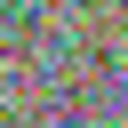
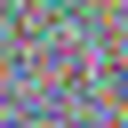
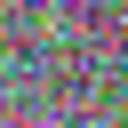
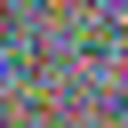
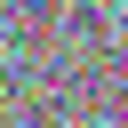
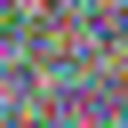
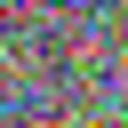
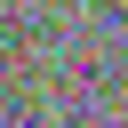
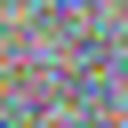
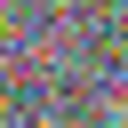
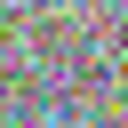
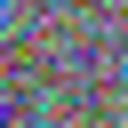
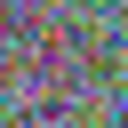
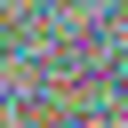
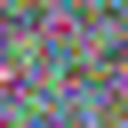
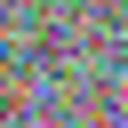
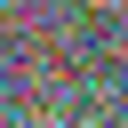
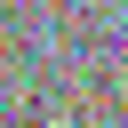
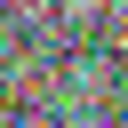
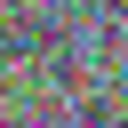

In [93]:
// torchvision.io.write_image()
let results = plot_sample(intermediate_ddpm)
// let surface = SKSurface.Create(imageInfo)
// let canvas = surface.Canvas
// canvas.DrawBitmap(results[0], SKPoint(0.0f, 0.0f))
// surface.Snapshot().Display()
results |> Array.map (fun result ->    
    let scaledImageInfo = SKImageInfo(128, 128, SKColorType.Bgra8888, SKAlphaType.Unpremul)
    result.Resize(scaledImageInfo, SKFilterQuality.High))

# View Epoch 2

In [109]:
// load in model weights and set to eval mode
nn_model.load($"{save_dir}/model_2.pth")
nn_model.eval()
Console.WriteLine("Loaded in Model")

Loaded in Model


In [110]:
let samples, intermediate_ddpm = sample_ddpm(32L, 20L)

index,value
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,

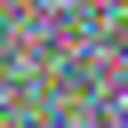
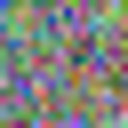
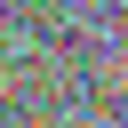
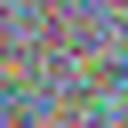
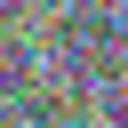
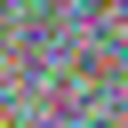
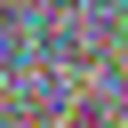
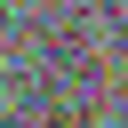
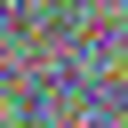
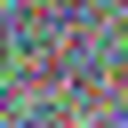
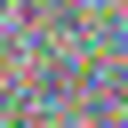
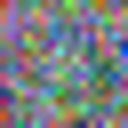
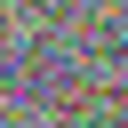
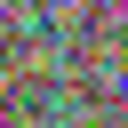
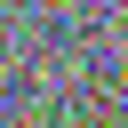
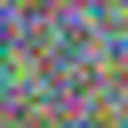
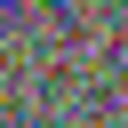
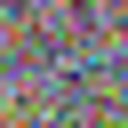
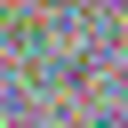
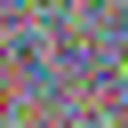

In [113]:
// torchvision.io.write_image()
let results = plot_sample(intermediate_ddpm)
// let surface = SKSurface.Create(imageInfo)
// let canvas = surface.Canvas
// canvas.DrawBitmap(results[0], SKPoint(0.0f, 0.0f))
// surface.Snapshot().Display()
results |> Array.map (fun result ->    
    let scaledImageInfo = SKImageInfo(128, 128, SKColorType.Bgra8888, SKAlphaType.Unpremul)
    result.Resize(scaledImageInfo, SKFilterQuality.High))